In [39]:
import numpy as np
import matplotlib.pyplot as plt


filepath = '../data/data.txt'
number_of_shells = 40

In [40]:
# first step is to read the data
base_data = np.genfromtxt(filepath, delimiter='	')
masses = base_data[:, 1]
positions = base_data[:, [2, 3, 4]]
velocities = base_data[:, [5, 6, 7]]
potentials = base_data[:, 9]
magnitudes = np.array([np.linalg.norm(pos) for pos in positions])


# total mass
M = np.sum(masses)
m = masses[0]
print(M)


# create a given number of shells
shells = np.logspace(np.log10(np.min(magnitudes)), np.log10(np.max(magnitudes)), number_of_shells)

# now we compute the density function
# here r1 must be smaller than r2
def density_function(r1, r2):
    # firstly we need to compute the number of planets inside of this ring
    mask = (magnitudes >= r1) & (magnitudes < r2)
    count = np.sum(mask)
    sigma = np.sqrt(count)
    # now we need to compute the volume of this sphere
    volume = 4/3 * np.pi * (r2**3 - r1**3)
    
    return (count * m)  / volume, (sigma * m) / volume


# plt the inferred density function
desities = []
bin_centers = []
sigmas = []
for i in range(number_of_shells - 1):
    # counts get normalised to 1
    ### The Hernquist function normalised the count to the total mass
    ### of the system, to make the comparison as fair as possible
    ### we also normalise the count to sum up to the total mass of the system
    
    density, sigma = density_function(shells[i], shells[i + 1])
    desities.append(density)
    sigmas.append(sigma)
    #bin_centers.append(0.5 * (shells[i + 1] - shells[i]))
    bin_centers.append(np.sqrt(shells[i]*shells[i+1]))
counts = np.array(desities)

plt.errorbar(bin_centers, desities, yerr=sigmas, linestyle='none', capsize=5, color='gray', zorder=1)
plt.scatter(bin_centers, desities, s=5, color='black', zorder=2, label='Inferred density function')


# plot the hernquist density function
# where r is the radius, 
# a is the characteristic scale radius
# M the total mass of the halo
def hernquist(r, a, M):
    return M * a * 1 / (2 * np.pi * r * (r + a)**3)

# we can compute a using some different ways
def a_from_half_mass_distance():
    # returns the distance in which half the mass is 
    # inside of the returned radius and half mass is outside
    sorted_mag = np.sort(magnitudes)
    return sorted_mag[int(len(sorted_mag) / 2)]

width = shells[1] - shells[0]
hq_counts = []

# formula for a from the original paper
a = a_from_half_mass_distance() / (1 + np.sqrt(2))
for i in range(number_of_shells - 1):
    center_position = np.sqrt(shells[i] * shells[i + 1])
    # counts get normalised to 1 
    count = hernquist(center_position, a, M)
    hq_counts.append(count)
hq_counts = np.array(hq_counts)

plt.plot(bin_centers, hq_counts, color='lightblue', zorder=0, label='Hernquist')
    

plt.title(f'Comparison between density function and Hernquist \n a = {a:.3f} is half mass radius')
plt.xlabel('Distance to center [a.u.]')
plt.ylabel('Denstiy [a.u.]')
plt.loglog()
plt.tight_layout()
plt.legend()
plt.savefig('comparison.pdf', dpi=1000)

FileNotFoundError: ../data/data.txt not found.

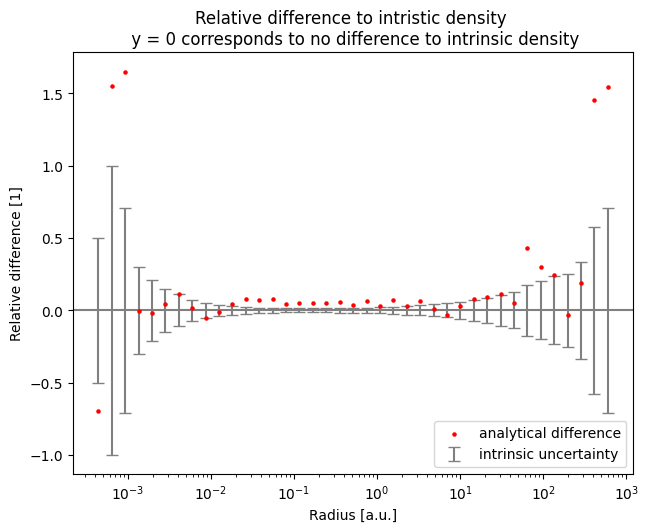

In [ ]:
densities, hq_densities, bin_centers, sigmas = desities, hq_counts, bin_centers, np.array(sigmas)


diff = (hq_densities - densities) / densities
_sigmas = sigmas / densities


# here I plot the value which we get from the distribution as the 0 line
# then the error point corresponds to the error of the analytical function
# which means the error bar must sit on the x axis

plt.scatter(bin_centers, diff, s=5, zorder=5, color='red', label='analytical difference')
plt.errorbar(bin_centers, np.zeros_like(bin_centers), yerr=_sigmas, linestyle='none', capsize=4, color='gray', zorder=2, label='intrinsic uncertainty')
plt.xscale('log')
plt.axhline(0, color='gray', zorder=0)

plt.tight_layout()
plt.title('Relative difference to intristic density \n y = 0 corresponds to no difference to intrinsic density')
plt.xlabel('Radius [a.u.]')
plt.ylabel('Relative difference [1]')
plt.legend()
plt.savefig('relative_difference_intrinsic.pdf', dpi=1000)

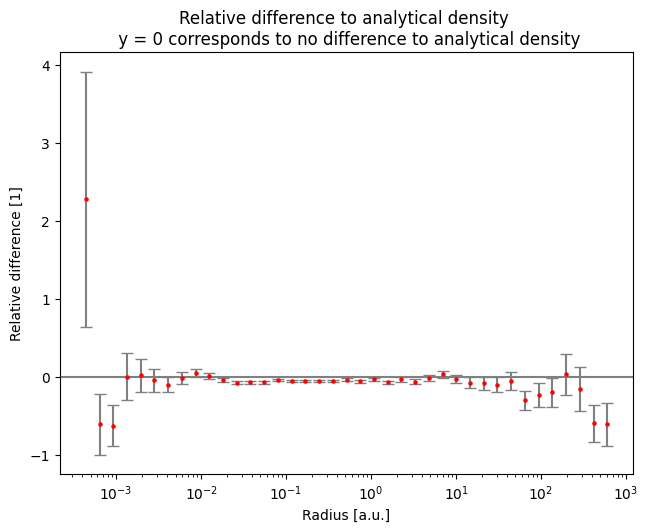

In [ ]:
densities, hq_densities, bin_centers, sigmas = desities, hq_counts, bin_centers, np.array(sigmas)


diff = (densities - hq_densities) / hq_densities
_sigmas = sigmas / hq_densities


# here I plot the value which we get from the distribution as the 0 line
# then the error point corresponds to the error of the analytical function
# which means the error bar must sit on the x axis

plt.scatter(bin_centers, diff, s=5, zorder=5, color='red', label='intrinsical difference')
plt.errorbar(bin_centers, diff, yerr=_sigmas, linestyle='none', capsize=4, color='gray', zorder=2, label='intrinsic uncertainty')
plt.xscale('log')
plt.axhline(0, color='gray', zorder=0)

plt.tight_layout()
plt.title('Relative difference to analytical density \n y = 0 corresponds to no difference to analytical density')
plt.xlabel('Radius [a.u.]')
plt.ylabel('Relative difference [1]')
plt.savefig('relative_difference_analytical.pdf', dpi=1000)


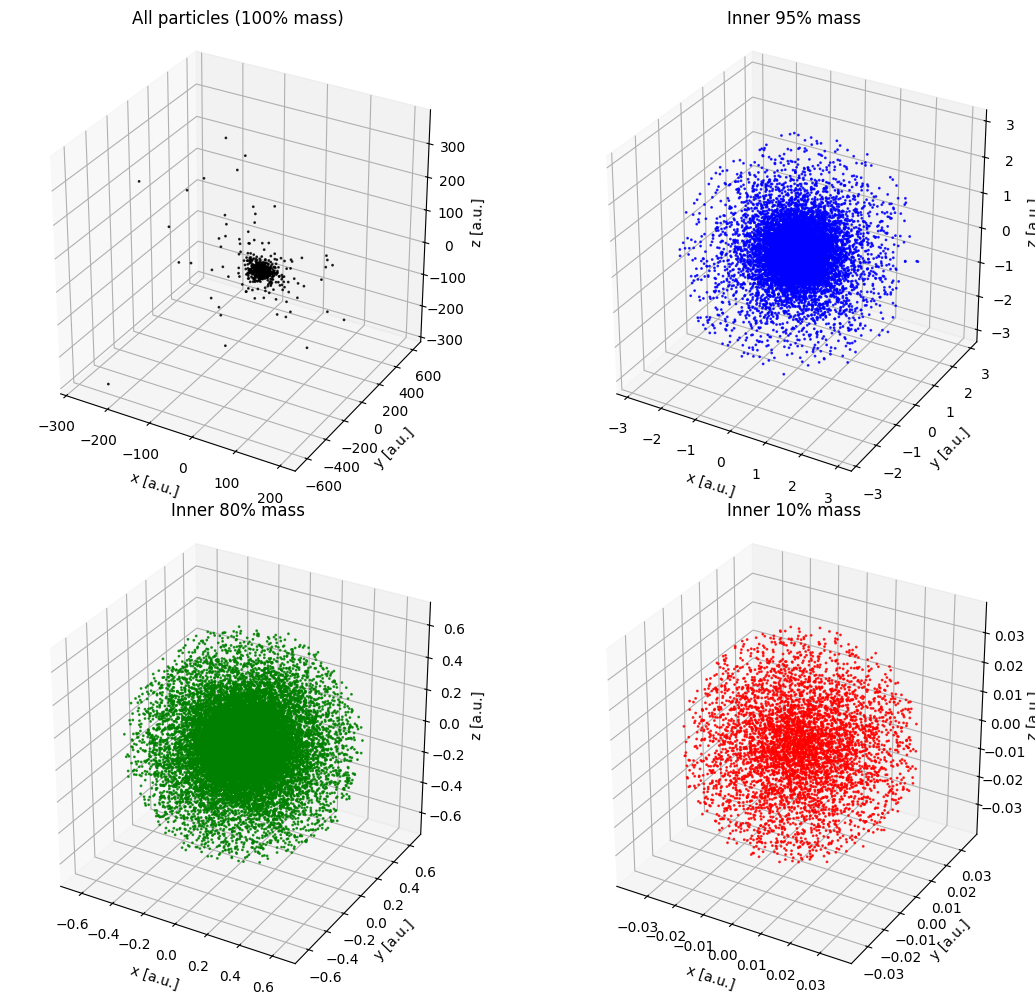

In [ ]:
# now lastly we create a nice plot showing inner subsets by cumulative mass
# positions is a Nx3 array of points, magnitudes is the distance array, masses holds particle masses
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# use the existing variables from earlier cells
pos = positions
mag = magnitudes
mass_arr = masses if 'masses' in globals() else np.ones(len(mag))

# sort by magnitude (inner -> outer)
idx_sorted = np.argsort(mag)
cum_mass = np.cumsum(mass_arr[idx_sorted])
total_mass = cum_mass[-1]

def select_inner_by_mass_fraction(frac):
    """Return indices (in original ordering) of particles comprising the inner `frac` fraction of total mass.
    frac is between 0 and 1.0 (1.0 -> all mass)."""
    if frac >= 1.0:
        return np.arange(len(pos))
    target = frac * total_mass
    # searchsorted gives the index where cum_mass >= target
    cutoff = np.searchsorted(cum_mass, target)
    # include up to cutoff (inclusive)
    return idx_sorted[:cutoff+1]

# Fractions to display: all, 95%, 80%, 10% (inner mass fractions)
fractions = [1.0, 0.95, 0.8, 0.10]
colors = ['black', 'blue', 'green', 'red']
titles = ['All particles (100% mass)', 'Inner 95% mass', 'Inner 80% mass', 'Inner 10% mass']

fig = plt.figure(figsize=(12,10))
for i, frac in enumerate(fractions):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    sel_idx = select_inner_by_mass_fraction(frac)
    p = pos[sel_idx]
    ax.scatter(p[:,0], p[:,1], p[:,2], s=1, c=colors[i], alpha=0.8)
    ax.set_title(titles[i])
    ax.set_xlabel('x [a.u.]')
    ax.set_ylabel('y [a.u.]')
    ax.set_zlabel('z [a.u.]')
    try:
        ax.set_box_aspect([1,1,1])
    except Exception:
        pass

plt.tight_layout()
plt.savefig('positions_2x2_cumMass.pdf', dpi=1000)
plt.show()
